# ResNet

In this notebook we'll be implementing one of the [ResNet](https://arxiv.org/abs/1512.03385) (Residual Network) model variants. ResNet was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in 2015.

ResNet, like VGG, also has multiple *configurations* which specify the number of layers and the sizes of those layers. Each layer is made out of *blocks*, which are made up of convolutional layers, batch normalization layers and *residual connections* (also called *skip connections* or *shortcut connections*). Confusingly, ResNets use the term "layer" to refer to both a set of blocks, e.g. "layer 1 has two blocks", and also the total number of layers within the entire ResNet, e.g. "ResNet18 has 18 layers".

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. Below is an example block with an identity residual connection, i.e. no layers in the residual path.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-skip.png?raw=1)

The different ResNet configurations are known by the total number of layers within them - ResNet18, ResNet34, ResNet50, ResNet101 and ResNet152. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-table.png?raw=1)

From the table above, we can see that for ResNet18 and ResNet34 that the first block contains two 3x3 convolutional layers with 64 filters, and that ResNet18 has two of these blocks in the first layer, whilst Resnet34 has three. ResNet50, ResNet101 and ResNet152 blocks have a different structure than those in ResNet18 and ResNet34, and these blocks are called *bottleneck* blocks. Bottleneck blocks reduce the number of number of channels within the input before expanding them back out again. Below shows a standard *BasicBlock* (left) - used by ResNet18 and ResNet34 - and the *Bottleneck* block used by ResNet50, ResNet101 and ResNet152.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-blocks.png?raw=1)

Why do ResNets work? The key is in the residual connections. Training incredibly deep neural networks is difficult due to the gradient signal either exploding (becoming very large) or vanishing (becoming very small) as it gets backpropagated through many layers. Residual connections allow the model to learn how to "skip" layers - by setting all their weights to zero and only rely on the residual connection. Thus, in theory, if your ResNet152 model can actually learn the desired function between input and output by only using the first 52 layers the remaining 100 layers should set their weights to zero and the output of the 52nd layer will simply pass through the residual connections unhindered. This also allows for the gradient signal to also backpropagate through those 100 layers unhindered too. This outcome could also also be achieved in a network without residual connections, the "skipped" layers would learn to set their weights to one, however adding the residual connection is more explicit and is easier for the model to learn to use these residual connections.

The image below shows a comparison between VGG-19, a convolutional neural network architecture without residual connections, and one with residual connections - ResNet34. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg-resnet.png?raw=1)

In this notebook we'll also be showing how to use torchvision to handle datasets that are not part of `torchvision.datasets`. Specificially we'll be using Via traffic sign dataset. This is a dataset with 7 different species of traffic sign. Each species has around 2000 images, which are around 128x128 pixels each. Our goal is to correctly determine which species an image belongs to - a 7-dimensional image classification problem.


We'll also be using a learning rate scheduler, a PyTorch wrapper around an optimizer which allows us to dynamically alter its learning rate during training. Specifically, we'll use the *one cycle learning learning rate scheduler*, also known as *superconvergnence*, from [this](https://arxiv.org/abs/1803.09820) paper and is commonly used in the [fast.ai course](https://course.fast.ai/).

### Data Processing

As always, we'll start by importing all the necessary modules. We have a few new imports here:
- `lr_scheduler` for using the one cycle learning rate scheduler
- `namedtuple` for handling ResNet configurations
- `os` and `shutil` for handling custom datasets

In [ ]:
!git clone https://github.com/ducnguyenhuynh/via-trafficsign-classification.git
!wget https://github.com/ducnguyenhuynh/via-trafficsign-classification/releases/download/via-tf-dataset/dataset.zip
!unzip dataset.zip
!mv dataset via-trafficsign-classification/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/4/09145.jpg  
  inflating: dataset/train/4/01012.jpg  
  inflating: dataset/train/4/06721.jpg  
  inflating: dataset/train/4/06870.jpg  
  inflating: dataset/train/4/06512.jpg  
  inflating: dataset/train/4/01452.jpg  
  inflating: dataset/train/4/03389.jpg  
  inflating: dataset/train/4/09106.jpg  
  inflating: dataset/train/4/06285.jpg  
  inflating: dataset/train/4/01250.jpg  
  inflating: dataset/train/4/09116.jpg  
  inflating: dataset/train/4/07091.jpg  
  inflating: dataset/train/4/09184.jpg  
  inflating: dataset/train/4/09109.jpg  
  inflating: dataset/train/4/06118.jpg  
  inflating: dataset/train/4/02472.jpg  
  inflating: dataset/train/4/06607.jpg  
  inflating: dataset/train/4/01247.jpg  
  inflating: dataset/train/4/08951.jpg  
  inflating: dataset/train/4/03219.jpg  
  inflating: dataset/train/4/03477.jpg  
  inflating: dataset/train/4/03247.jpg  
  inflating: dataset/train/4/09163.jpg  
  infl

In [5]:
cd via-trafficsign-classification/resnet

/content/via-trafficsign-classification/resnet


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from dataloader import Dataloader
from models import *
from utils import *



import copy
from collections import namedtuple
import os
import random
import shutil
import time

To handle using custom datasets, torchvision provides a [`datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) class. 

`ImageFolder` expects data to be stored in the following way:

```
root/class_x/xxy.png
root/class_x/xxz.jpg

root/class_y/123.jpeg
root/class_y/nsdf3.png
root/class_y/asd932_.jpg
```

That is, each folder in the root directory is the name of a class, and within each of those folders are the images that correspond to that class. The images in the downloaded dataset are currently in the form of:

```
dataset/train/class_a/image_1.jpg
dataset/train/class_b/image_2.jpg

dataset/test/class_a/image_1.jpg
dataset/test/class_a/image_2.jpg

```

This means we could call `datasets.ImageFolder(root = '.data/train/images)` and it would load all of the data. 

We first set a `TRAIN_RATIO` which will decide what percentage of the images per class are used to make up the training set, with the remainder making up the test set. We create a `train` and `test` folder within the `dataset` folder - after first deleting them if they already exist. Then, we get a list of all classes and loop through each class. For each class we get the image names, use the first `TRAIN_RATIO` of them for the training set and the remainder for the test set. We then copy - with `shutil.copyfile` - each of the images into their respective `train` or `test` folder. It is usually better to copy, rather than move, the images to create your custom splits just in case we accidentally mess up somewhere.


In [7]:
dataloader = Dataloader("../dataset", image_size = 128) 

train_data, valid_data, test_data =  dataloader.get_dataset()

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                shuffle = True, 
                                batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [8]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [9]:
%matplotlib inline
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure.Figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

We can see the images look fine, however the names of the classes provided by the folders containing the images are a little long and sometimes overlap with neighbouring images.


In [10]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
# labels = ["stop", "left", "right", "straight", "no left", "no right", "unknown"]
classes = test_data.classes

plot_images(images, labels, classes)

### Defining the Model

Next up, we'll be defining our model. As mentioned previously, we'll be using one of the residual network (ResNet) models. Let's look at the ResNet configuration table again:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-table.png?raw=1)

As we can see, there is a common 7x7 convolutional layer and max pooling layer at the start of all ResNet models - these layers also have padding, which is not shown in the table. These are followed by four "layers", each containing a different number of blocks. There are two different blocks used, one for the ResNet18 and ResNet34 - called the `BasicBlock` - , and one for the ResNet50, ResNet101 and ResNet152 - called the `Bottleneck` block.

Our `ResNet` class defines the initial 7x7 convolutional layer along with batch normalization, a ReLU activation function and a downsampling max pooling layer. We then build the four layers from the provided configuration, `config`, which specifies: the block to use, the number of blocks in the layer, and the number of channels in that layer. For the `BasicBlock` the number of channels in a layer is simply the number of filters for both of the convolutional layers within the block. For the `Bottleneck` block, the number of channels refers to the number of filters used by the first two convolutional layers - the number of the filters in the final layer is the number of channels multiplied by an `expansion` factor, which is 4 for the `Bottleneck` block (and 1 for the `BasicBlock`). Also note that the `stride` of the first layer is one, whilst the `stride` of the last three layers is two. This `stride` is only used to change the `stride` of the first convolutional layer within a block and also in the "downsampling" residual path - we'll explain what downsampling in ResNets means shortly.

`get_resnet_layer` is used to define the layers from the configuration by creating a `nn.Sequential` from a list of blocks. The first thing it checks is if the first block in a layer needs to have a downsampling residual path - only the first block within a layer ever needs to have a downsampling residual path. So, what is a downsampling residual path?

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-skip.png?raw=1)

Remember that the key concept in the ResNet models is the residual (aka skip/identity) connection. However, if the number of channels within the image is changed in the main connection of the block then it won't have the same number of channels as the image from the residual connection and thus we cannot sum them together. Consider the first block in second layer of ResNet18, the image tensor passed to it will have 64 channels and the output will have 128 channels. Thus, we need to make a residual connection between a 64 channel tensor and a 128 channel tensor. ResNet models solve this using a downsampling connection - technically, it doesn't always downsample the image as sometimes the image height and width stay the same - which increases the number of channels in the image through the residual connection by passing them through a convolutional layer. 

Thus, to check if we need to downsample within a block or not, we simply check if the number of channels into the block - `in_channels` - is the number of channels out of the block - defined by the `channels` argument multipled by the `expansion` factor of the block. Only the first block in each layer is checked if it needs to downsample or not. After each layer is created, we update `in_channels` to be the number of channels of the image when it is output by the layer.

We then follow the four layers with a 1x1 adaptive average pool. This will take the average over the entire height and width of the image separately for each channel. Thus, if the input to the average pool is `[512, 7, 7]` (512 channels and a height and width of seven) then the output of the average pool will be `[512, 1, 1]`. We then pass this average pooled output to a linear layer to make a prediction. We always know how many channels will be in the image after the fourth layer as we continuously update `in_channels` to be equal to the number of the channels in the image output by each layer.

One thing to note is that the initial convolutional layer has `bias = False`, which means there is no bias term used by the filters. In fact, every convolutional layer used within every ResNet model always has `bias = False`. The authors of the ResNet paper argue that the bias terms are unnecessary as every convolutional layer in a ResNet is followed by a batch normalization layer which has a $\beta$ (beta) term that does the same thing as the bias term in the convolutional layer, a simple addition. See the previous notebook for more details on how batch normalization works.

In [11]:
pretrained_model = models.resnet18(pretrained = True)

We can see that the final linear layer for the classification, `fc`, has a 1000-dimensional output as it was pre-trained on the ImageNet dataset, which has 1000 classes. 

In [12]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

Then, we replace the pre-trained model's linear layer with our own, randomly initialized linear layer.

**Note:** even if our dataset had 1000 classes, the same as ImageNet, we would still remove the linear layer and replace it with a randomly initialized one as our classes are not equal to those of ImageNet. 

In [14]:
pretrained_model.fc = fc

The pre-trained ResNet model provided by torchvision does not provide an intermediate output, which we'd like to potentially use for analysis. We solve this by initializing our own ResNet18 model and then copying the pre-trained parameters into our model.

We then initialize our ResNet18 model from the configuration...

In [15]:
model = ResNet(resnet18_config, OUTPUT_DIM)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,180,103 trainable parameters


### Training the Model

Next we'll move on to training our model. As in previous notebooks, we'll use the learning rate finder to set a suitable learning rate for our model.

We start by initializing an optimizer with a very low learning rate, defining a loss function (`criterion`) and device, and then placing the model and the loss function on to the device.

In [17]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We define the learning rate finder class.

See notebook 3 for a reminder on how this works.

In [18]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Stopping early, the loss has diverged


In [21]:
from pylab import *
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

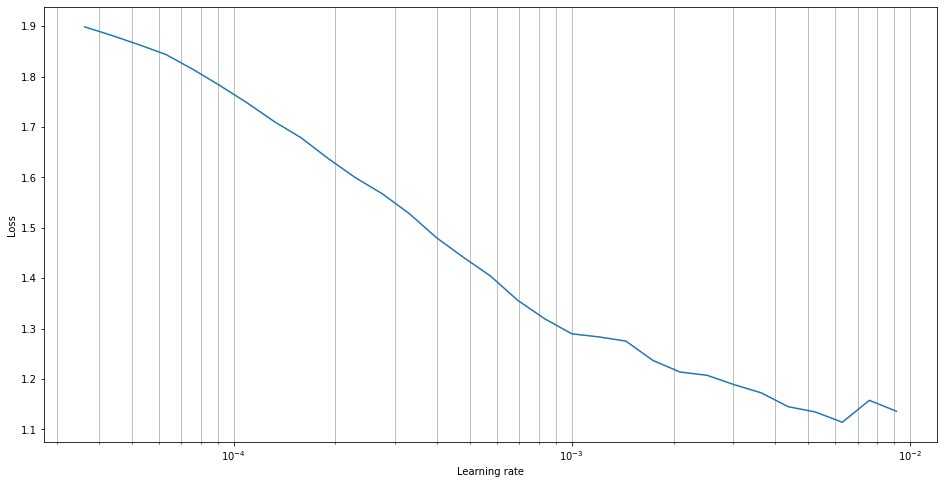

In [22]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [23]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [24]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH + 100

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [25]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [26]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [27]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

Finally, we can train our model!

We get around 80% top-1 and 95% top-5 validation accuracy.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 0.495 | Train Acc @1:  83.71% | Train Acc @5:  98.92%
	Valid Loss: 0.129 | Valid Acc @1:  96.07% | Valid Acc @5:  99.93%
Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.082 | Train Acc @1:  97.50% | Train Acc @5: 100.00%
	Valid Loss: 0.090 | Valid Acc @1:  96.85% | Valid Acc @5:  99.93%
Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.052 | Train Acc @1:  98.45% | Train Acc @5:  99.98%
	Valid Loss: 0.064 | Valid Acc @1:  98.20% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 0.035 | Train Acc @1:  99.02% | Train Acc @5: 100.00%
	Valid Loss: 0.047 | Valid Acc @1:  98.82% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 30s
	Train Loss: 0.028 | Train Acc @1:  99.31% | Train Acc @5: 100.00%
	Valid Loss: 0.038 | Valid Acc @1:  98.98% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.013 | Train Acc @1:  99.57% | Train Acc @5: 100.00%
	Valid Loss: 0.034 | Valid Acc @1:  99.08% | Valid Acc @5: 100.00%
Epoch: 07 

The test accuracies are a little lower than the validation accuracies, but not by so much that we should be concerned.

In [31]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.199 | Test Acc @1:  96.67% | Test Acc @5:  99.73%


### Examining the Model

We'll be doing the same examinations of the model as done in previous notebooks.

First, we get the predictions for each image in the test set...

In [32]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [33]:
images, labels, probs = get_predictions(model, test_iterator)

In [34]:
pred_labels = torch.argmax(probs, 1)

In [37]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (15, 15));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

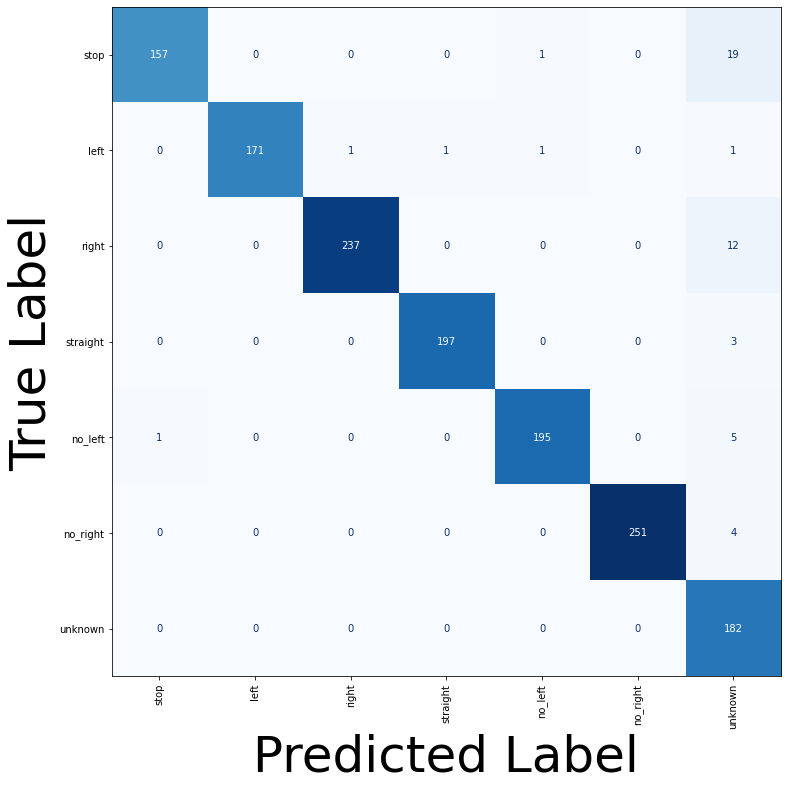

In [38]:
classes = ['stop','left','right','straight','no_left','no_right','unknown']
plot_confusion_matrix(labels, pred_labels, classes)

We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [39]:
corrects = torch.eq(labels, pred_labels)

In [40]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [41]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

From the names of the classes (and a bit of image searching) we can see that the incorrect predictions are usually sensible, e.g. magnolia warbler and cape may warbler, marsh wren and carolina wren.

The most incorrectly predicted image might also be a mislabeled example as worm eating warblers do not have a black and white underside.

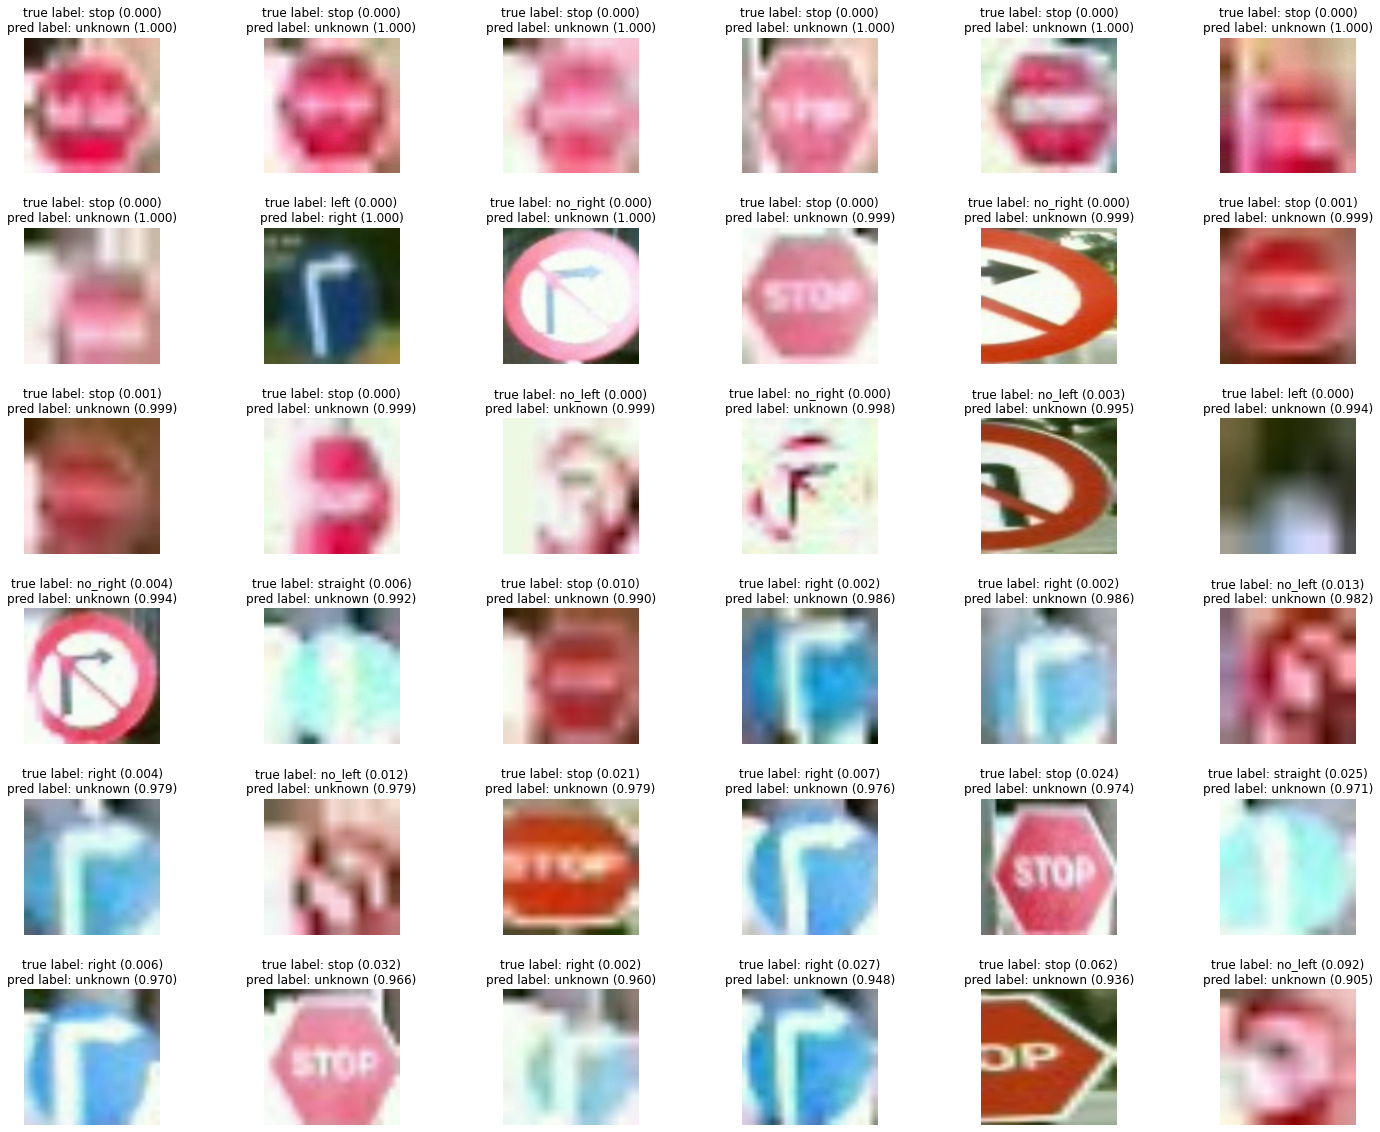

In [42]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)